# !!! Before running each R script change the setting of the working directory !!! 

In [111]:
#Python libraries needed for the script:
#bioinfokit.analys, rpy2, matplotlib.pyplot, pandas, numpy, io, matplotlib_venn

In [112]:
#R libraries needed for the script:
#tidyverse, DESeq2, edgeR, GenomicFeatures, scales, dplyr

In [113]:
from bioinfokit.analys import gff
%load_ext rpy2.ipython
import matplotlib.pyplot as plt
from rpy2.robjects import r, pandas2ri
import pandas as pd
from bioinfokit.analys import norm, get_data
import numpy as np
from matplotlib_venn import venn2
from matplotlib_venn import venn3
from io import StringIO

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# !!!Already done!!! Convert gff3 file (with information about exonic regions) to gtf

In [114]:
# already done
#gff.gff_to_gtf(file="BoPac.tsebra.pref_braker1.gff3", trn_feature_name="intron")

#final gtf file used for subsequent analysis: BoPac.tsebra.pref_braker1_exon_number_bypy_clean.gtf

# Production of the file BoPac.tsebra.pref_braker1_exon_number_bypy_clean_exon_length.csv 

In [115]:
#The BoPac.tsebra.pref_braker1_exon_number_bypy_clean_exon_length.csv file was 
#obtained by filtering the scaffold and exon columns, while the exon_length column 
#was generated by subtracting the start coordinate from the end coordinate 
#in the BoPac.tsebra.pref_braker1_exon_number_bypy_clean.gtf file.

In [116]:
gtf_file = pd.read_table("BoPac.tsebra.pref_braker1_exon_number_bypy_clean.gtf", sep="\t", header=None)

In [117]:
gtf_exon_file = gtf_file[gtf_file[2].str.startswith('exon', na=False)]

In [118]:
gtf_exon_file['exon_length'] = gtf_exon_file[4]-gtf_exon_file[3]

/tmp/ipykernel_9154/1418019906.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gtf_exon_file['exon_length'] = gtf_exon_file[4]-gtf_exon_file[3]


In [119]:
gtf_exon_length_file = gtf_exon_file.drop([1, 2, 3, 4, 5, 6, 7], axis=1)

In [120]:
gtf_exon_length_file=gtf_exon_length_file.rename(columns={0: "scaffold", 8: "exon"})

In [121]:
gtf_exon_length_file.to_csv('BoPac.tsebra.pref_braker1_exon_number_exon_length_UNCLEAN.csv', sep='\t', index=False)

In [122]:
#cleaning gtf_exon_length_file_clean
!awk -F'\t' 'BEGIN { OFS="\t"; print "scaffold\texon\texon_length" } NR>1 { split($2, a, "\""); print $1, a[8], $3 }' BoPac.tsebra.pref_braker1_exon_number_exon_length_UNCLEAN.csv > BoPac.tsebra.pref_braker1_exon_number_bypy_clean_exon_length.csv
!rm BoPac.tsebra.pref_braker1_exon_number_exon_length_UNCLEAN.csv

# Production of the file BoPac.tsebra.pref_braker1_exon_number_bypy_clean_coordinates.bed

In [123]:
#The BoPac.tsebra.pref_braker1_exon_number_bypy_clean_coordinates.bed file was 
#obtained by filtering the scaffold, star, end and exon columns, 
#from only the exon row in the 3rd column in BoPac.tsebra.pref_braker1_exon_number_bypy_clean.gtf file.

In [124]:
gtf_exon_bed_file = gtf_exon_file.drop([1, 2, 5, 6, 7, 'exon_length'], axis=1)

In [125]:
gtf_exon_bed_file=gtf_exon_bed_file.rename(columns={0: "scaffold", 3: "start", 4: "end", 8: "exon"})

In [126]:
gtf_exon_bed_file.to_csv('BoPac.tsebra.pref_braker1_exon_number_bypy_exon_coordinates_UNCLEAN.bed', sep='\t', header=False, index=False)

In [127]:
#cleaning gtf_exon_bed_file
!awk -F'\t' '{ split($4, a, "\""); print $1, $2, $3, a[8] }' OFS='\t' BoPac.tsebra.pref_braker1_exon_number_bypy_exon_coordinates_UNCLEAN.bed > BoPac.tsebra.pref_braker1_exon_number_bypy_clean_coordinates.bed
!rm BoPac.tsebra.pref_braker1_exon_number_bypy_exon_coordinates_UNCLEAN.bed

# Production of the file BoPac.tsebra.pref_braker1_exon_number_bypy_clean_strand_type.gtf

In [128]:
gtf_exon_file.to_csv('BoPac.tsebra.pref_braker1_only_exon.csv', sep='\t', index=False, header=None)

In [129]:
#production of BoPac.tsebra.pref_braker1_exon_number_bypy_clean_strand_type.gtf
!awk -F'\t' '{ split($9, a, "\""); print a[8], $7 }' OFS='\t' BoPac.tsebra.pref_braker1_only_exon.csv > BoPac.tsebra.pref_braker1_exon_number_bypy_partial_clean_strand_type.gtf
!awk 'BEGIN { print "exon\tstrand" } { print }' BoPac.tsebra.pref_braker1_exon_number_bypy_partial_clean_strand_type.gtf > BoPac.tsebra.pref_braker1_exon_number_bypy_clean_strand_type.gtf
!rm BoPac.tsebra.pref_braker1_only_exon.csv
!rm BoPac.tsebra.pref_braker1_exon_number_bypy_partial_clean_strand_type.gtf

## Merging exon lenght htseq-count

In [133]:
all_quant_htseq = pd.read_table("all_quant_htseq--nonunique all.csv", sep='\t')
exon_length = pd.read_table("BoPac.tsebra.pref_braker1_exon_number_bypy_clean_exon_length.csv", sep='\t')

In [136]:
all_quant_htseq_exon_length = pd.merge(all_quant_htseq, exon_length, on="exon")

In [137]:
all_quant_htseq_exon_length.to_csv('all_quant_htseq_exon_length.csv', sep=',', index=False)

### Subsampling Htseq-count and filtering out exons that do not have at least one reads in all samples

In [138]:
%R source('RNA_count_filt.R')

o{'value': <rpy2.rinterface_lib.sexp.NULLType object at 0x79a6a1abb700> [RTYPES.NILSXP], 'visible': [1] FALSE
, }

In [139]:
df_miscellaneous = pd.read_table("all_quant_htseq_exon_length_1_reads_filt_miscellaneous.csv", sep=',', index_col='exon')
df_brain = pd.read_table("all_quant_htseq_exon_length_1_reads_filt_brain.csv", sep=',', index_col='exon')
df_gonads = pd.read_table("all_quant_htseq_exon_length_1_reads_filt_gonads.csv", sep=',', index_col='exon')

In [140]:
df_miscellaneous = df_miscellaneous.drop(['scaffold'], axis=1)
df_brain = df_brain.drop(['scaffold'], axis=1)
df_gonads = df_gonads.drop(['scaffold'], axis=1)

### Normalization of reads count in TPM (transcript per million) 

In [141]:
# normalize miscellaneous raw counts using TPM method
# gene length must be in bp
nm = norm()
nm.tpm(df=df_miscellaneous, gl='exon_length')
# get TPM normalized dataframe
tpm_df_miscellaneous = nm.tpm_norm

# normalize brain raw counts using TPM method
# gene length must be in bp
nm = norm()
nm.tpm(df=df_brain, gl='exon_length')
# get TPM normalized dataframe
tpm_df_brain = nm.tpm_norm

# normalize gonads raw counts using TPM method
# gene length must be in bp
nm = norm()
nm.tpm(df=df_gonads, gl='exon_length')
# get TPM normalized dataframe
tpm_df_gonads = nm.tpm_norm

In [142]:
#tpm_df_miscellaneous.to_csv('all_quant_htseq_TPM_Norm_1_reads_filt.csv', sep=',', index=True)
#tpm_df_brain.to_csv('all_quant_htseq_TPM_Norm_1_reads_filt.csv', sep=',', index=True)
#tpm_df_gonads.to_csv('all_quant_htseq_TPM_Norm_1_reads_filt.csv', sep=',', index=True)

In [143]:
tpm_df_miscellaneous['average_TPM'] = tpm_df_miscellaneous.mean(axis=1)
tpm_df_brain['average_TPM'] = tpm_df_brain.mean(axis=1)
tpm_df_gonads['average_TPM'] = tpm_df_gonads.mean(axis=1)

In [144]:
tpm_df_miscellaneous.to_csv('all_quant_htseq_miscellaneous_TPM_Norm_1_reads_filt_averaged.csv', sep=',', index=True)
tpm_df_brain.to_csv('all_quant_htseq_brain_TPM_Norm_1_reads_filt_averaged.csv', sep=',', index=True)
tpm_df_gonads.to_csv('all_quant_htseq_gonads_TPM_Norm_1_reads_filt_averaged.csv', sep=',', index=True)

In [147]:
gene_counts_length = pd.read_table("BoPac.tsebra.pref_braker1_exon_number_bypy_clean_exon_length.csv", sep='\t')

### Merging of normalized counts with exon lengths

In [148]:
result_df_miscellaneous = pd.merge(tpm_df_miscellaneous, gene_counts_length, on="exon")
result_df_brain = pd.merge(tpm_df_brain, gene_counts_length, on="exon")
result_df_gonads = pd.merge(tpm_df_gonads, gene_counts_length, on="exon")

In [149]:
result_df_miscellaneous = result_df_miscellaneous.drop(['scaffold'], axis=1)
result_df_brain = result_df_brain.drop(['scaffold'], axis=1)
result_df_gonads = result_df_gonads.drop(['scaffold'], axis=1)

In [150]:
result_df_miscellaneous.to_csv('all_quant_htseq_miscellaneous_TPM_Norm_1_reads_filt_averaged_exon_lengths.csv', sep=',', index=False)
result_df_brain.to_csv('all_quant_htseq_brain_TPM_Norm_1_reads_filt_averaged_exon_lengths.csv', sep=',', index=False)
result_df_gonads.to_csv('all_quant_htseq_gonads_TPM_Norm_1_reads_filt_averaged_exon_lengths.csv', sep=',', index=False)

In [151]:
df_average_TPM_exon_length_miscellaneous = result_df_miscellaneous[['average_TPM', 'exon_length']]
df_average_TPM_exon_length_brain = result_df_brain[['average_TPM', 'exon_length']]
df_average_TPM_exon_length_gonads = result_df_gonads[['average_TPM', 'exon_length']]

In [152]:
df_average_TPM_exon_length_miscellaneous.to_csv('average_TPM-exon_length_1_reads_filt_miscellaneous.csv', sep=',', index=False)
df_average_TPM_exon_length_brain.to_csv('average_TPM-exon_length_1_reads_filt_brain.csv', sep=',', index=False)
df_average_TPM_exon_length_gonads.to_csv('average_TPM-exon_length_1_reads_filt_gonads.csv', sep=',', index=False)

### Removal for each tissue of exons that are less than 150 bp in size

In [153]:
%R source('exon_length_filtering.R')

o{'value': <rpy2.rinterface_lib.sexp.NULLType object at 0x79a6a1abb700> [RTYPES.NILSXP], 'visible': [1] FALSE
, }

## R script for:
### - Selection of high expression exons by sorting the average expression decreasingly and summing the length of exons until 7Mb is reached
### - Selection of low expression exons by sorting the average expression in ascending order and summing the length of exons until 7Mb is reached

### in every tissue

In [154]:
%R source('extract_exon_by_7Mb_spam.R')

o{'value': <rpy2.rinterface_lib.sexp.NULLType object at 0x79a6a1abb700> [RTYPES.NILSXP], 'visible': [1] FALSE
, }

# Extraction of exonic regions

In [167]:
annotation = pd.read_csv('BoPac.tsebra.pref_braker1_exon_number_bypy_clean_coordinates.bed',header= None, sep='\t')

In [169]:
annotation = annotation.rename(columns={0: "scaffold", 1: "start", 2: "end", 3: "exon"})

### Selection of high-expression exons based on the 7 Mb span for each tissue

In [170]:
high_7Mb_misscellaneous = pd.read_csv('TPM_Norm_1_reads_filt_averaged_exon_lengths>150_HIGH_EXP_7Mb_spam_miscellaneous.csv', sep=",")
high_7Mb_brain = pd.read_csv('TPM_Norm_1_reads_filt_averaged_exon_lengths>150_HIGH_EXP_7Mb_spam_brain.csv', sep=",")
high_7Mb_gonads = pd.read_csv('TPM_Norm_1_reads_filt_averaged_exon_lengths>150_HIGH_EXP_7Mb_spam_gonads.csv', sep=",")

In [171]:
high_exon_7Mb_misscellaneous = set(high_7Mb_misscellaneous['exon'])
high_exon_7Mb_brain = set(high_7Mb_brain['exon'])
high_exon_7Mb_gonads = set(high_7Mb_gonads['exon'])

#### venn plot realization

In [172]:
venn_data = {
    'Table_high_exon_misscellaneous': high_exon_7Mb_misscellaneous,
    'Table_high_exon_brain': high_exon_7Mb_brain,
    'Table_high_exon_gonads': high_exon_7Mb_gonads
}

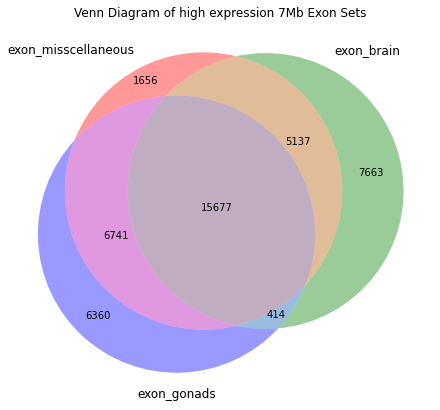

In [173]:
plt.figure(figsize=(10,7))
venn = venn3([venn_data['Table_high_exon_misscellaneous'], venn_data['Table_high_exon_brain'], venn_data['Table_high_exon_gonads']],
             ('exon_misscellaneous', 'exon_brain', 'exon_gonads'))

plt.title("Venn Diagram of high expression 7Mb Exon Sets")
plt.savefig("Venn Diagram of high expression 7Mb Exon Sets.pdf")
plt.show()

In [174]:
intersection_1_2 = high_exon_7Mb_misscellaneous.intersection(high_exon_7Mb_brain)
intersection_1_3 = high_exon_7Mb_misscellaneous.intersection(high_exon_7Mb_gonads)
intersection_2_3 = high_exon_7Mb_brain.intersection(high_exon_7Mb_gonads)
intersection_1_2_3 = high_exon_7Mb_misscellaneous.intersection(high_exon_7Mb_brain).intersection(high_exon_7Mb_gonads)

In [175]:
high_exp_7Mb_intersections_df = pd.DataFrame({
    'exon_misscellaneous_and_exon_brain': pd.Series(list(intersection_1_2)),
    'exon_misscellaneous_and_exon_gonads': pd.Series(list(intersection_1_3)),
    'exon_brain_and_exon_gonads': pd.Series(list(intersection_2_3)),
    'exon_misscellaneous_and_exon_brain_and_exon_gonads': pd.Series(list(intersection_1_2_3))
})

In [176]:
high_exp_7Mb_intersections_df.to_csv('high_exp_exon_7Mb_intersections.csv', index=False)

In [177]:
high_exp_7Mb_exon = pd.concat([high_7Mb_misscellaneous['exon'], high_7Mb_brain['exon'], high_7Mb_gonads['exon']]).drop_duplicates().reset_index(drop=True)

In [178]:
high_exp_7Mb_exon_coord = pd.merge(high_exp_7Mb_exon, annotation, on="exon")

In [179]:
high_exp_7Mb_exon_coord['exon_lenght'] = high_exp_7Mb_exon_coord['end']-high_exp_7Mb_exon_coord['start']

In [180]:
high_exp_7Mb_exon_coord.to_csv('high_exp_exon_7Mb_coord-lenght.csv', index=False)

### Selection of low-expression exons based on the 7 Mb span for each tissue

In [181]:
low_7Mb_misscellaneous = pd.read_csv('TPM_Norm_1_reads_filt_averaged_exon_lengths>150_LOW_EXP_7Mb_spam_miscellaneous.csv', sep=",")
low_7Mb_brain = pd.read_csv('TPM_Norm_1_reads_filt_averaged_exon_lengths>150_LOW_EXP_7Mb_spam_brain.csv', sep=",")
low_7Mb_gonads = pd.read_csv('TPM_Norm_1_reads_filt_averaged_exon_lengths>150_LOW_EXP_7Mb_spam_gonads.csv', sep=",")

In [182]:
low_exon_7Mb_misscellaneous = set(low_7Mb_misscellaneous['exon'])
low_exon_7Mb_brain = set(low_7Mb_brain['exon'])
low_exon_7Mb_gonads = set(low_7Mb_gonads['exon'])

#### venn plot realization

In [183]:
venn_data = {
    'Table_low_exon_misscellaneous': low_exon_7Mb_misscellaneous,
    'Table_low_exon_brain': low_exon_7Mb_brain,
    'Table_low_exon_gonads': low_exon_7Mb_gonads
}

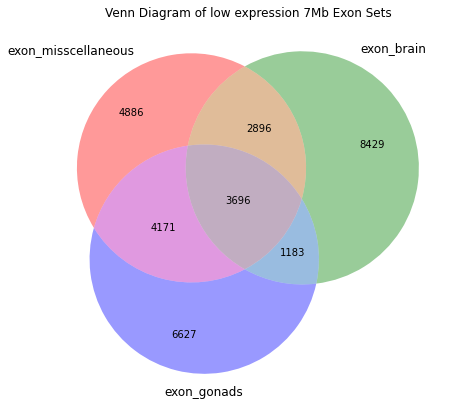

In [184]:
plt.figure(figsize=(10,7))
venn = venn3([venn_data['Table_low_exon_misscellaneous'], venn_data['Table_low_exon_brain'], venn_data['Table_low_exon_gonads']],
             ('exon_misscellaneous', 'exon_brain', 'exon_gonads'))

plt.title("Venn Diagram of low expression 7Mb Exon Sets")
plt.savefig("Venn Diagram of low expression 7Mb Exon Sets.pdf")
plt.show()

In [185]:
intersection_1_2 = low_exon_7Mb_misscellaneous.intersection(low_exon_7Mb_brain)
intersection_1_3 = low_exon_7Mb_misscellaneous.intersection(low_exon_7Mb_gonads)
intersection_2_3 = low_exon_7Mb_brain.intersection(low_exon_7Mb_gonads)
intersection_1_2_3 = low_exon_7Mb_misscellaneous.intersection(low_exon_7Mb_brain).intersection(low_exon_7Mb_gonads)

In [186]:
low_exp_7Mb_intersections_df = pd.DataFrame({
    'exon_misscellaneous_and_exon_brain': pd.Series(list(intersection_1_2)),
    'exon_misscellaneous_and_exon_gonads': pd.Series(list(intersection_1_3)),
    'exon_brain_and_exon_gonads': pd.Series(list(intersection_2_3)),
    'exon_misscellaneous_and_exon_brain_and_exon_gonads': pd.Series(list(intersection_1_2_3))
})

In [187]:
low_exp_7Mb_intersections_df.to_csv('low_exp_exon_7Mb_intersections.csv', index=False)

In [188]:
low_exp_7Mb_exon = pd.concat([low_7Mb_misscellaneous['exon'], low_7Mb_brain['exon'], low_7Mb_gonads['exon']]).drop_duplicates().reset_index(drop=True)

In [189]:
low_exp_7Mb_exon_coord = pd.merge(low_exp_7Mb_exon, annotation, on="exon")

In [190]:
low_exp_7Mb_exon_coord['exon_lenght'] = low_exp_7Mb_exon_coord['end']-low_exp_7Mb_exon_coord['start']

In [191]:
low_exp_7Mb_exon_coord.to_csv('low_exp_exon_7Mb_coord-lenght.csv', index=False)

# Removal of intersecting high and low expression exons

In [192]:
high_7Mb = pd.read_csv('high_exp_exon_7Mb_coord-lenght.csv', sep=",")
low_7Mb = pd.read_csv('low_exp_exon_7Mb_coord-lenght.csv', sep=",")

In [193]:
high_7Mb_exon = set(high_7Mb['exon'])
low_7Mb_exon = set(low_7Mb['exon'])

In [194]:
venn_data = {
    'Table_high_exon': high_7Mb_exon,
    'Table_low_exon': low_7Mb_exon,
}

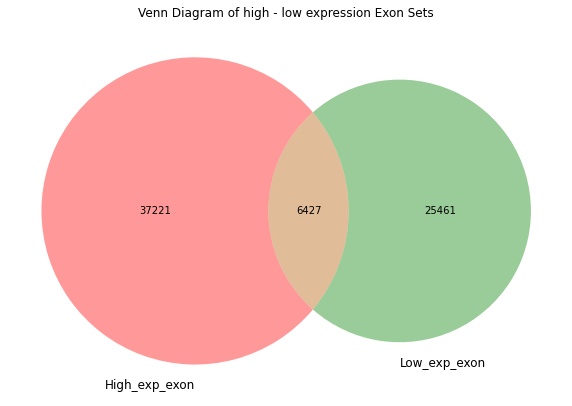

In [195]:
plt.figure(figsize=(10,7))
venn = venn2([venn_data['Table_high_exon'], venn_data['Table_low_exon']],
             ('High_exp_exon', 'Low_exp_exon'))

plt.title("Venn Diagram of high - low expression Exon Sets")
plt.savefig("Venn Diagram of high - low expression Exon Sets.pdf")
plt.show()

In [196]:
intersection_high_low = high_7Mb_exon.intersection(low_7Mb_exon)

In [197]:
high_low_intersections_df = pd.DataFrame({
    'exon': pd.Series(list(intersection_high_low))})

In [198]:
only_high_exp_exon_coord = high_7Mb[~high_7Mb['exon'].isin(high_low_intersections_df['exon'])]

In [199]:
only_low_exp_exon_coord = low_7Mb[~low_7Mb['exon'].isin(high_low_intersections_df['exon'])]

In [200]:
only_low_exp_exon_coord.to_csv('only_low_exp_exon_7Mb_coord-lenght.csv', index=False)

In [201]:
only_high_exp_exon_coord.to_csv('only_high_exp_exon_7Mb_coord-lenght.csv', index=False)

# Removal of duplicate exons on the basis of coordinates

In [202]:
only_low_exp_exon_coord_unique = only_low_exp_exon_coord.drop_duplicates(subset=["start", "end", "scaffold"])

In [203]:
only_high_exp_exon_coord_unique = only_high_exp_exon_coord.drop_duplicates(subset=["start", "end", "scaffold"])

In [204]:
only_low_exp_exon_coord_unique.to_csv('only_low_exp_UNIQUE_exon_7Mb_coord-lenght.csv', index=False)

In [205]:
only_high_exp_exon_coord_unique.to_csv('only_high_exp_UNIQUE_exon_7Mb_coord-lenght.csv', index=False)

# Addition of tissue information to high expression exons

#### Function to update the column based on the presence of the tissue

In [206]:
def update_tissue_column(df, tissue_df, tissue_name, column_name):
    df[column_name] = df['exon'].isin(tissue_df['exon']).replace({True: tissue_name, False: ''})
    return df

#### Add columns with tissue name if exon is present

In [207]:
only_high_exp_exon_coord_unique = update_tissue_column(only_high_exp_exon_coord_unique, high_7Mb_misscellaneous, 'miscellaneous', 'in_miscellaneous')
only_high_exp_exon_coord_unique = update_tissue_column(only_high_exp_exon_coord_unique, high_7Mb_brain, 'brain', 'in_brain')
only_high_exp_exon_coord_unique = update_tissue_column(only_high_exp_exon_coord_unique, high_7Mb_gonads, 'gonads', 'in_gonads')


/tmp/ipykernel_9154/3148341875.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df['exon'].isin(tissue_df['exon']).replace({True: tissue_name, False: ''})
/tmp/ipykernel_9154/3148341875.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df['exon'].isin(tissue_df['exon']).replace({True: tissue_name, False: ''})
/tmp/ipykernel_9154/3148341875.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [208]:
only_high_exp_exon_coord_unique_tissue = only_high_exp_exon_coord_unique.replace('', pd.NA).dropna(axis=1, how='all')

#### Function to remove NAs from the table

In [209]:
def concatenate_non_na(row):
    parts = [row['exon']]
    if not pd.isna(row['in_miscellaneous']):
        parts.append(row['in_miscellaneous'])
    if not pd.isna(row['in_brain']):
        parts.append(row['in_brain'])
    if not pd.isna(row['in_gonads']):
        parts.append(row['in_gonads'])
    return '|'.join(parts)

In [210]:
only_high_exp_exon_coord_unique_tissue['exon_tissue'] = only_high_exp_exon_coord_unique.apply(concatenate_non_na, axis=1)

In [211]:
only_high_exp_exon_coord_unique_tissue.drop(columns=['in_miscellaneous', 'in_brain', 'in_gonads'], inplace=True)

In [212]:
only_high_exp_exon_coord_unique_tissue.to_csv('only_high_exp_UNIQUE_exon_7Mb_coord-length_tissue.csv', index=False)
only_high_exp_exon_coord_unique_tissue.to_csv('only_high_exp_UNIQUE_exon_7Mb_coord-length_tissue.bed', index=False, sep="\t" )

# Addition of tissue information to low expression exons

In [213]:
only_low_exp_exon_coord_unique = update_tissue_column(only_low_exp_exon_coord_unique, low_7Mb_misscellaneous, 'miscellaneous', 'in_miscellaneous')
only_low_exp_exon_coord_unique = update_tissue_column(only_low_exp_exon_coord_unique, low_7Mb_brain, 'brain', 'in_brain')
only_low_exp_exon_coord_unique = update_tissue_column(only_low_exp_exon_coord_unique, low_7Mb_gonads, 'gonads', 'in_gonads')

/tmp/ipykernel_9154/3148341875.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df['exon'].isin(tissue_df['exon']).replace({True: tissue_name, False: ''})
/tmp/ipykernel_9154/3148341875.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column_name] = df['exon'].isin(tissue_df['exon']).replace({True: tissue_name, False: ''})
/tmp/ipykernel_9154/3148341875.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [214]:
only_low_exp_exon_coord_unique_tissue = only_low_exp_exon_coord_unique.replace('', pd.NA).dropna(axis=1, how='all')

In [215]:
only_low_exp_exon_coord_unique_tissue['exon_tissue'] = only_low_exp_exon_coord_unique.apply(concatenate_non_na, axis=1)

In [216]:
only_low_exp_exon_coord_unique_tissue.drop(columns=['in_miscellaneous', 'in_brain', 'in_gonads'], inplace=True)

In [217]:
only_low_exp_exon_coord_unique_tissue.to_csv('only_low_exp_UNIQUE_exon_7Mb_coord-length_tissue.csv', index=False)
only_low_exp_exon_coord_unique_tissue.to_csv('only_low_exp_UNIQUE_exon_7Mb_coord-length_tissue.bed', index=False, sep="\t")

# Adding strand type to bed files

In [218]:
annotation_strand_type = pd.read_csv('BoPac.tsebra.pref_braker1_exon_number_bypy_clean_strand_type.gtf', sep="\t")
bed_file_high = pd.read_csv('only_high_exp_UNIQUE_exon_7Mb_coord-length_tissue.bed', sep="\t")
bed_file_low = pd.read_csv('only_low_exp_UNIQUE_exon_7Mb_coord-length_tissue.bed', sep="\t")

In [219]:
bed_file_high_strand_type = pd.merge(bed_file_high, annotation_strand_type, on="exon")
bed_file_low_strand_type = pd.merge(bed_file_low, annotation_strand_type, on="exon")

In [220]:
bed_file_high_strand_type["info_strand"]=bed_file_high_strand_type["exon_tissue"] + "|" + bed_file_high_strand_type["strand"]
bed_file_low_strand_type["info_strand"]=bed_file_low_strand_type["exon_tissue"] + "|" + bed_file_low_strand_type["strand"]

In [221]:
bed_file_high_strand_type.drop(bed_file_high_strand_type.columns[[0, 4, 5, 6]], axis=1, inplace=True)
bed_file_low_strand_type.drop(bed_file_low_strand_type.columns[[0, 4, 5, 6]], axis=1, inplace=True)

In [222]:
bed_file_low_strand_type.to_csv('only_low_exp_UNIQUE_exon_7Mb_coord_tissue_strand_type.bed', index=False, sep="\t", header=False)

In [223]:
bed_file_high_strand_type.to_csv('only_high_exp_UNIQUE_exon_7Mb_coord_tissue_strand_type.bed', index=False, sep="\t", header=False)

In [224]:
!awk '{gsub(/\|\|\|/, "|"); gsub(/\|\|/, "|"); print}' only_high_exp_UNIQUE_exon_7Mb_coord_tissue_strand_type.bed > only_high_exp_UNIQUE_exon_7Mb_coord_tissue_strand_type_clean.bed
!awk '{gsub(/\|\|\|/, "|"); gsub(/\|\|/, "|"); print}' only_low_exp_UNIQUE_exon_7Mb_coord_tissue_strand_type.bed > only_low_exp_UNIQUE_exon_7Mb_coord_tissue_strand_type_clean.bed

# Merging of overlapping exonic regions

In [225]:
!cat only_low_exp_UNIQUE_exon_7Mb_coord_tissue_strand_type_clean.bed | sort -k1,1 -k2n | bedtools merge -c 4 -o collapse > only_low_exp_UNIQUE_exon_7Mb_coord_tissue_strand_type_merged.bed
!cat only_high_exp_UNIQUE_exon_7Mb_coord_tissue_strand_type_clean.bed | sort -k1,1 -k2n | bedtools merge -c 4 -o collapse > only_high_exp_UNIQUE_exon_7Mb_coord_tissue_strand_type_merged.bed

In [226]:
cat only_high_exp_UNIQUE_exon_7Mb_coord_tissue_strand_type_clean.bed | sort -k1,1 -k2n | bedtools merge -c 4 -o collapse | awk '{sum+=$3-$2-1} END {print sum}'

5491569


In [227]:
cat only_low_exp_UNIQUE_exon_7Mb_coord_tissue_strand_type_clean.bed | sort -k1,1 -k2n | bedtools merge -c 4 -o collapse | awk '{sum+=$3-$2-1} END {print sum}'

7191093
